#### Libraries

In [1]:
!pip install numpy==1.19.3
!pip install mediapipe

import matplotlib.pyplot as plt
import mediapipe as mp
import pandas as pd
import numpy as np
import json
import cv2
import re
from PIL import Image
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.optimizers import Nadam 
from tensorflow.keras import layers

from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 14.9 MB 22.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 32.7 MB 58.6 MB/s 
Mounted at /content/drive


#### Functions

In [2]:
def get_capacitive_values(data_path):
    #Samples before and after init
    N = 800
    # Opening JSON file
    f = open(data_path)
    # returns JSON object as a dictionary
    dict_json = json.load(f)
    df = pd.DataFrame(dict_json)
    # Closing file
    f.close()
    
    #Get data from right channel:
    face_right_channel_eyebrows = df["cap_1_0"].to_list()
    face_right_channel_mouth= df["cap_1_1"].to_list()
    face_right_channel_nose= df["cap_1_2"].to_list()
    face_right_channel_cheekbones= df["cap_1_3"].to_list()
    
    #Substract the mean value for each channel.
    #Right channels:
    face_right_channel_eyebrows = (face_right_channel_eyebrows - np.mean(face_right_channel_eyebrows)).tolist()
    face_right_channel_cheekbones = (face_right_channel_cheekbones - np.mean(face_right_channel_cheekbones)).tolist()
    face_right_channel_nose = (face_right_channel_nose - np.mean(face_right_channel_nose)).tolist()
    face_right_channel_mouth = (face_right_channel_mouth - np.mean(face_right_channel_mouth)).tolist()
    
    #Get Min Value from Initial signal:
    min_values = []
    max_val = min(face_right_channel_eyebrows[0:N])
    max_index_right_channel_eyebrows = face_right_channel_eyebrows.index(max_val)
    min_values.append((max_val,max_index_right_channel_eyebrows))
    max_val = min(face_right_channel_mouth[0:N])
    max_index_right_channel_mouth = face_right_channel_mouth.index(max_val)
    min_values.append((max_val,max_index_right_channel_mouth))
    max_val = min(face_right_channel_nose[0:N])
    max_index_right_channel_nose = face_right_channel_nose.index(max_val)
    min_values.append((max_val,max_index_right_channel_nose))
    max_val = min(face_right_channel_cheekbones[0:N])
    max_index_right_channel_cheekbones = face_right_channel_cheekbones.index(max_val)
    min_values.append((max_val,max_index_right_channel_cheekbones))
    
    min_all = (0,0)
    for tup in min_values:
        if tup[0] < min_all[0]:
            min_all = tup
    print("Init Synch (Value,Index):", min_all)
    
    #Get Min Value from End signal:
    min_values = []
    max_val = min(face_right_channel_eyebrows[len(face_right_channel_eyebrows)-N:len(face_right_channel_eyebrows)])
    max_index_right_channel_eyebrows = face_right_channel_eyebrows.index(max_val)
    min_values.append((max_val,max_index_right_channel_eyebrows))
    max_val = min(face_right_channel_mouth[len(face_right_channel_eyebrows)-N:len(face_right_channel_eyebrows)])
    max_index_right_channel_mouth = face_right_channel_mouth.index(max_val)
    min_values.append((max_val,max_index_right_channel_mouth))
    max_val = min(face_right_channel_nose[len(face_right_channel_eyebrows)-N:len(face_right_channel_eyebrows)])
    max_index_right_channel_nose = face_right_channel_nose.index(max_val)
    min_values.append((max_val,max_index_right_channel_nose))
    max_val = min(face_right_channel_cheekbones[len(face_right_channel_eyebrows)-N:len(face_right_channel_eyebrows)])
    max_index_right_channel_cheekbones = face_right_channel_cheekbones.index(max_val)
    min_values.append((max_val,max_index_right_channel_cheekbones))
    
    min_all = (0,0)
    for tup in min_values:
        if tup[0] < min_all[0]:
            min_all = tup
    print("Ending Synch (Value,Index):", min_all)
    
    #PLOT Right Face Sections - Without OFFSET
    plt.figure(figsize=(15, 5))
    plt.plot(face_right_channel_eyebrows)
    plt.plot(max_index_right_channel_eyebrows,face_right_channel_eyebrows[max_index_right_channel_eyebrows], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
    plt.plot(face_right_channel_cheekbones)
    plt.plot(max_index_right_channel_cheekbones,face_right_channel_cheekbones[max_index_right_channel_cheekbones], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="blue")
    plt.plot(face_right_channel_nose)
    plt.plot(max_index_right_channel_nose,face_right_channel_nose[max_index_right_channel_nose], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="yellow")
    plt.plot(face_right_channel_mouth)
    plt.plot(max_index_right_channel_mouth,face_right_channel_mouth[max_index_right_channel_mouth], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
    plt.title('Right Face Sections - Without OFFSET')
    plt.xlabel('Samples')
    plt.ylabel('DataX')
    plt.grid()
    plt.show()
      
    T=2
    plt.title('Left Face Sections - FFT')
    yf = fft(face_right_channel_eyebrows)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_right_channel_cheekbones)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_right_channel_nose)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_right_channel_mouth)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.show()

    ###################################################################################################################
    
    #Get data from left channel:
    face_left_channel_eyebrows = df["cap_0_0"].to_list()
    face_left_channel_mouth= df["cap_0_1"].to_list()
    face_left_channel_nose= df["cap_0_2"].to_list()
    face_left_channel_cheekbones= df["cap_0_3"].to_list()
    
    #Left channels:
    face_left_channel_eyebrows = (face_left_channel_eyebrows - np.mean(face_left_channel_eyebrows)).tolist()
    face_left_channel_cheekbones = (face_left_channel_cheekbones - np.mean(face_left_channel_cheekbones)).tolist()
    face_left_channel_nose = (face_left_channel_nose - np.mean(face_left_channel_nose)).tolist()
    face_left_channel_mouth = (face_left_channel_mouth - np.mean(face_left_channel_mouth)).tolist()
    
    #Get Min Value from Initial signal:
    min_values = []
    max_val = min(face_left_channel_eyebrows[0:N])
    max_index_left_channel_eyebrows = face_left_channel_eyebrows.index(max_val)
    min_values.append((max_val,max_index_left_channel_eyebrows))
    max_val = min(face_left_channel_mouth[0:N])
    max_index_left_channel_mouth = face_left_channel_mouth.index(max_val)
    min_values.append((max_val,max_index_left_channel_mouth))
    max_val = min(face_left_channel_nose[0:N])
    max_index_left_channel_nose = face_left_channel_nose.index(max_val)
    min_values.append((max_val,max_index_left_channel_nose))
    max_val = min(face_left_channel_cheekbones[0:N])
    max_index_left_channel_cheekbones = face_left_channel_cheekbones.index(max_val)
    min_values.append((max_val,max_index_left_channel_cheekbones))
    
    min_all = (0,0)
    for tup in min_values:
        if tup[0] < min_all[0]:
            min_all = tup
    print("Init Synch (Value,Index):", min_all)
    
    #Get Min Value from End signal: 
    min_values = []
    max_val = min(face_left_channel_eyebrows[len(face_left_channel_eyebrows)-N:len(face_left_channel_eyebrows)])
    max_index_left_channel_eyebrows = face_left_channel_eyebrows.index(max_val)
    min_values.append((max_val,max_index_left_channel_eyebrows))
    max_val = min(face_left_channel_mouth[len(face_left_channel_eyebrows)-N:len(face_left_channel_eyebrows)])
    max_index_left_channel_mouth = face_left_channel_mouth.index(max_val)
    min_values.append((max_val,max_index_left_channel_mouth))
    max_val = min(face_left_channel_nose[len(face_left_channel_eyebrows)-N:len(face_left_channel_eyebrows)])
    max_index_left_channel_nose = face_left_channel_nose.index(max_val)
    min_values.append((max_val,max_index_left_channel_nose))
    max_val = min(face_left_channel_cheekbones[len(face_left_channel_eyebrows)-N:len(face_left_channel_eyebrows)])
    max_index_left_channel_cheekbones = face_left_channel_cheekbones.index(max_val)
    min_values.append((max_val,max_index_left_channel_cheekbones))
    
    min_all = (0,0)
    for tup in min_values:
        if tup[0] < min_all[0]:
            min_all = tup
    print("Ending Synch (Value,Index):", min_all)
    
    #PLOT Left Face Sections - Without OFFSET
    plt.figure(figsize=(15, 5))
    plt.plot(face_left_channel_eyebrows)
    plt.plot(max_index_left_channel_eyebrows,face_left_channel_eyebrows[max_index_left_channel_eyebrows], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
    plt.plot(face_left_channel_cheekbones)
    plt.plot(max_index_left_channel_cheekbones,face_left_channel_cheekbones[max_index_left_channel_cheekbones], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
    plt.plot(face_left_channel_nose)
    plt.plot(max_index_left_channel_nose,face_left_channel_nose[max_index_left_channel_nose], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
    plt.plot(face_left_channel_mouth)
    plt.plot(max_index_left_channel_mouth,face_left_channel_mouth[max_index_left_channel_mouth], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
    plt.title('Left Face Sections - Without OFFSET')
    plt.xlabel('Samples')
    plt.ylabel('DataX')
    plt.grid()
    plt.show()
    
    plt.title('Left Face Sections - FFT')
    yf = fft(face_left_channel_eyebrows)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_left_channel_cheekbones)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_left_channel_nose)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_left_channel_mouth)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.show()

    face_dict = {
        "Right-Eyebrows": face_right_channel_eyebrows,
        "Left-Eyebrows": face_left_channel_eyebrows,
        "Right-Cheekbones": face_right_channel_cheekbones,
        "Left-Cheekbones": face_left_channel_cheekbones,
        "Right-Nose": face_right_channel_nose,
        "Left-Nose": face_left_channel_nose,
        "Right-Mouth": face_right_channel_mouth,
        "Left-Mouth": face_left_channel_mouth
      }
  
    df = pd.DataFrame(face_dict)

    return df

In [ ]:
# Generate multivariate features with window_size from parallel secuences.
def generate_input_time_slices(dataframe, window_cap_size, n_feature_values):
    x = []
    for i in range(len(dataframe.index)):
        end_step = i + window_cap_size
        out_end_ix = end_step + window_cap_size
        if out_end_ix > len(dataframe.index):
            break
        # Separate time feature values from time target values.
        x.append(dataframe.iloc[i:end_step, 0:n_feature_values].values)
        
    return np.array(x)

In [ ]:
# Generate multivariate features with window_size from parallel sequences.
def generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample):
    coordinates = []
    i = 0
    while (i <= len(dataset_facelandmarks_x)-downsample-1):
        
        x_new, y_new, z_new = np.array(dataset_facelandmarks_x[i]), np.array(dataset_facelandmarks_y[i]), np.array(dataset_facelandmarks_z[i])
        
        for j in range(downsample-1):
            
            x_new = x_new + np.array(dataset_facelandmarks_x[(j+1)+i])
            y_new = y_new + np.array(dataset_facelandmarks_y[(j+1)+i])
            z_new = z_new + np.array(dataset_facelandmarks_z[(j+1)+i])
        
        i = i + downsample
        coordinates.append([x_new,y_new,z_new])
        
    return (np.array(coordinates)/downsample)

In [ ]:
def normalize_capacitance_values(dataset_cap):

  min_max_scaler = preprocessing.MinMaxScaler()
  scaled_dataset = min_max_scaler.fit_transform(dataset_cap)
  scaled_dataset = pd.DataFrame(scaled_dataset)

  return scaled_dataset

In [ ]:
# Split Train/Test dataset:
def split_train_test(x_time_features, y_time_targets):
    X_train, X_test, y_train, y_test = train_test_split(x_time_features, y_time_targets, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
# Consider facelandmarks data starting from the frame in which the hand was detected + 90 frames (3 secs = sync_thr*3 because freq of video is 30Hz) to stabilize capacitive data after hand touch.
def sync_facelandmarks(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found, sync_thr):
  
  sync = frame_hand_found + 3*sync_thr
  dataset_facelandmarks_x = dataset_facelandmarks_x[sync:len(dataset_facelandmarks_x)]
  dataset_facelandmarks_y = dataset_facelandmarks_y[sync:len(dataset_facelandmarks_y)]
  dataset_facelandmarks_z = dataset_facelandmarks_z[sync:len(dataset_facelandmarks_z)]

  return dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z


In [ ]:
# Consider data capacitive data after hand touch on left mouth antena + 30 (3 secs = sync_thr because freq of cap acquisition is 10Hz).
def sync_cap(dataset_cap, frame_hand_found, sync_thr):
  
  pulse = dataset_cap["Left-Mouth"].idxmax()
  sync = pulse + sync_thr
  dataset_cap = dataset_cap[sync:len(dataset_cap)]

  return dataset_cap

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint
#n_samples_train = 59498
n_samples_train = 3000
### Preprocessing of TRAIN Images ###
i = 0
train = []
for i in range(n_samples_train-2):
    # Change name of file to read.
    img_number = str(i+1)
    img_path = "/content/drive/MyDrive/Image_FacePoints_Train/myfig" + img_number + ".png"
    a = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (256, 256), interpolation = cv2.INTER_CUBIC)
    a = a[..., np.newaxis]
    train.append(a)

train = np.asarray(train)
train = train/255.
#Aumentamos la data de TRAIN ya que tenemos pocas imagánes y las normalizamos:
#train_datagenerator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.05,
#                                         height_shift_range = 0.05, shear_range = 0.05, zoom_range = 0.05,
 #                                        horizontal_flip = False,)

#Aplicamos los objetos de Data Generator a nuestos datasets:
#train_set = train_datagenerator.flow(train, batch_size = 64)

print("-------------------- Total Images --------------------")
print("Total size TRAIN Set:", train.shape)

### Preprocessing of TEST Images ###
#n_samples_test = 15367
n_samples_test = 150
i = 0
test = []
for i in range(n_samples_test-2):
    # Change name of file to read.
    img_number = str(i+1)
    img_path = "/content/drive/MyDrive/Image_FacePoints_Test/myfig" + img_number + ".png"
    a = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (256, 256), interpolation = cv2.INTER_CUBIC)
    a = a[..., np.newaxis]
    test.append(a)

test = np.asarray(test)
test = test/255.

print("-------------------- Total Images --------------------")
print("Total size TEST Set:", test.shape)

-------------------- Total Images --------------------
Total size TRAIN Set: (2998, 256, 256, 1)
-------------------- Total Images --------------------
Total size TEST Set: (148, 256, 256, 1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256)]        0         
                                                                 
 sequential (Sequential)     (None, 100)               824870    
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 1)       832961    
                                                                 
Total params: 1,657,831
Trainable params: 1,657,639
Non-trainable params: 192
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D 

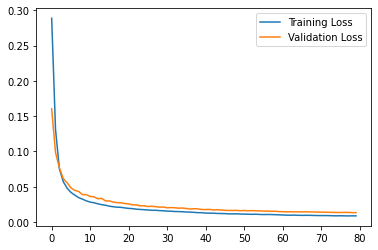

In [ ]:
#2D-CNN Autoencoder (Latent Space = Flaten Vector):

# Parameters:
dropoutrate = 0.2
kernel_size = (3,3)
encoded_dim = 100

#Build Encoder.
encoder_CNN = Sequential([
Conv2D(filters = 16, kernel_size = kernel_size, activation='leaky_relu', padding='same', kernel_initializer = "he_uniform", input_shape= (256, 256, 1)),
MaxPooling2D(2),
BatchNormalization(),
Dropout(dropoutrate),
Conv2D(filters = 32, kernel_size = kernel_size, activation='leaky_relu', padding='same', kernel_initializer = "he_uniform"),
MaxPooling2D(2),
BatchNormalization(),
Dropout(dropoutrate),
Conv2D(filters = 2, kernel_size = kernel_size, activation='leaky_relu', padding='same', kernel_initializer = "he_uniform"),
Flatten(),
Dense(encoded_dim, activation='leaky_relu', kernel_initializer = "he_uniform"),
])

#Build Decoder.
decoder_CNN = Sequential ([
Dense(8192, activation='relu', kernel_initializer = "he_uniform", input_shape=(encoded_dim,)),
Reshape((64,64,2)),
Conv2DTranspose(filters = 32, kernel_size = kernel_size, padding='same', activation='leaky_relu', kernel_initializer = "he_uniform"),
UpSampling2D(2),
BatchNormalization(),
Conv2DTranspose(filters=16, kernel_size = kernel_size, padding='same', activation='leaky_relu', kernel_initializer = "he_uniform"),
UpSampling2D(2),
BatchNormalization(),
Conv2DTranspose(filters=1, kernel_size = kernel_size, padding="same", activation = "sigmoid", kernel_initializer = "he_uniform")
])

#Merge models to Autoencoder.
input = Input(shape=(train.shape[1], train.shape[2]))
output = encoder_CNN(input)
output = decoder_CNN(output)
conv_autoencoder_CNN = Model(inputs = input, outputs = output)
nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
conv_autoencoder_CNN.compile(optimizer=nadam, loss='mse')
conv_autoencoder_CNN.summary()
conv_autoencoder_CNN.layers[1].summary()
conv_autoencoder_CNN.layers[2].summary()

history = conv_autoencoder_CNN.fit(train, train, batch_size=128, epochs=80, validation_split=0.2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
conv_autoencoder_CNN.save('/content/drive/MyDrive/Models/conv_autoencoder_CNN.h5')
decoder_CNN.save('/content/drive/MyDrive/Models/decoder_CNN.h5')
encoder_CNN.save('/content/drive/MyDrive/Models/encoder_CNN.h5')

In [ ]:
encoder_CNN = tf.keras.models.load_model('/content/drive/MyDrive/Models/encoder_CNN.h5')
decoder_CNN = tf.keras.models.load_model('/content/drive/MyDrive/Models/decoder_CNN.h5')

In [ ]:
#Calculate Test dataset RMSE - Conv Autoencoder (Latent Space = Vector)
test_pred = conv_autoencoder_CNN.predict(test)

#test_pred = test_pred.transpose(0,2,1)
#test = test.transpose(0,2,1)

print("-------------------- Test Evaluation Results--------------------")
test_mae_loss = np.sqrt(np.mean(((test_pred - test)*(test_pred - test)), axis=0)).mean()
print("Test MAE: ", test_mae_loss)

-------------------- Test Evaluation Results--------------------
Test MAE:  0.05796154867233833


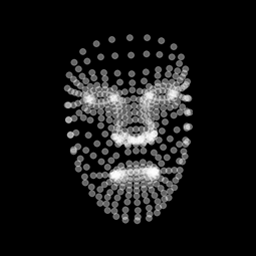

In [ ]:
img = test[50]*255.
img = img.astype(int)
img = img[:, :, 0]
cv2_imshow(img)

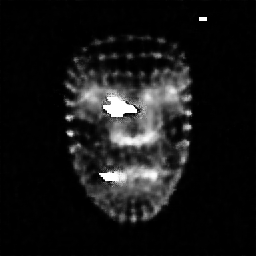

In [ ]:
img = test_pred[50]*255.
img = img.astype(int)
img = img[:, :, 0]
cv2_imshow(img)

In [ ]:
from random import randrange
vector = []
for n in range(100): 
  ran_input = randrange(255)
  ran_input = ran_input/255.
  vector.append(ran_input)
vector=np.array(vector)
vector = vector[None,:]
output = decoder_vector(vector).numpy()
output = output[0,:,:,0]
img = output*255.
cv2_imshow(img)

#### FaceLandmarks Data Processing for Autoencoder - (Using Raw FacePoints): ####

In [ ]:
data_from_videos = 1
n_samples = 1
downsample = 1
total_instances = []

for i in range(n_samples):
    # Change name of file to read.
    file_number = str(i+1)
    if (data_from_videos):
      video_path = "/content/drive/MyDrive/Face_Videos/Video_Face (" + file_number + ").MOV"
      # Read FaceLandmarks from Video.
      dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found_init, frame_hand_found_end = get_facelandmarks_video(video_path)
      print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
      print("Point Start Synchronization - Video #" + str(file_number) + ":", frame_hand_found_init)
      print("Point End Synchronization - Video #" + str(file_number) + ":", frame_hand_found_end)
      # Generate train features and target from windowing process.
      instance = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
      np.save("/content/drive/MyDrive/FaceLandmarks_numpy/Video_Face("+ file_number +").npy", instance)
    else:
      video_path = "/content/drive/MyDrive/FaceLandmarks_numpy/Video_Face(" + file_number + ").npy"
      instance = np.load(video_path)
      print("Number of Frames in Video #" + str(file_number) + ": ", len(instance))
      #Eliminate Z channel:
      new_instance = []
      for data in instance:
        new_instance.append([data[0],data[1]])
      instance = np.asarray(new_instance)   

    # If it is the first generation of time features.
    if (i == 0):
        total_instances = instance
    # If it is not the first generation of time features.
    else:
        total_instances = np.concatenate((total_instances, instance), axis=0)

print("-------------------- Features & Target Dimensions --------------------")
print("Total size of FaceLandMarks instances:", total_instances.shape)

#Split Train and Test dataset:
#Transpose to shift dimension between coordinates and facelandsmark points.
total_instances_trans = total_instances.transpose(0,2,1)

print("Shape of FaceLandMarks after Transpose(0,2,1):", total_instances_trans.shape)
#Get train and test data.
ratio_test = 0.1
test = total_instances_trans[:round(ratio_test*len(total_instances))-1]
train = total_instances_trans[round(ratio_test*len(total_instances)):len(total_instances)]
print("Shape of Train:", train.shape)
print("Shape of Test:", test.shape)

Number of Frames in Video #1:  1383
Point Start Synchronization - Video #1: 856
Point End Synchronization - Video #1: 0
-------------------- Features & Target Dimensions --------------------
Total size of FaceLandMarks instances: (1382, 3, 468)
Shape of FaceLandMarks after Transpose(0,2,1): (1382, 468, 3)
Shape of Train: (1244, 468, 3)
Shape of Test: (137, 468, 3)


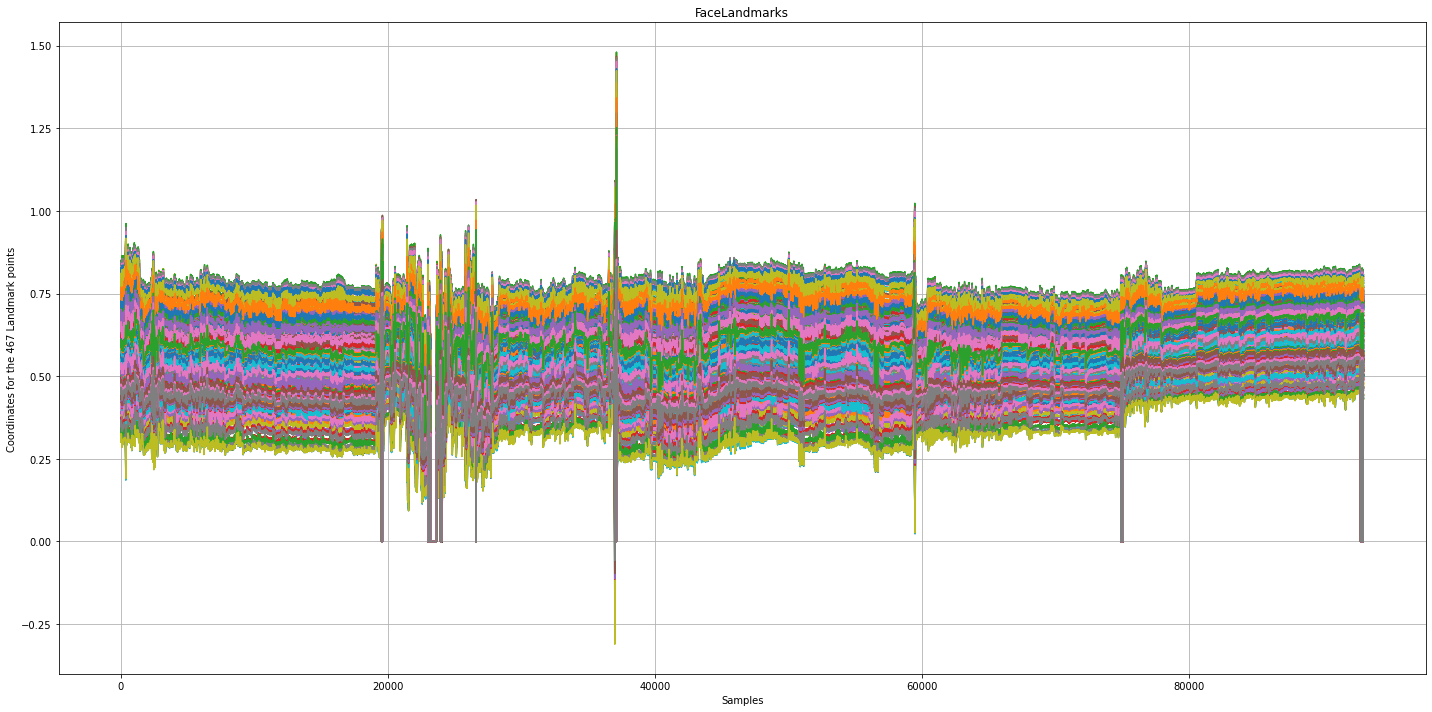

In [ ]:
points_x = total_instances_trans[:,:,0]
points_y = total_instances_trans[:,:,1]
#points_z = total_instances_trans[:,:,2]

plt.figure(figsize=(20,10))
#plt.plot(points_x)
plt.plot(points_y)
plt.title('FaceLandmarks')
plt.xlabel('Samples')
plt.ylabel('Coordinates for the 467 Landmark points')
plt.grid()
plt.show()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 468, 2)]          0         
                                                                 
 sequential_6 (Sequential)   (None, 80)                10452     
                                                                 
 sequential_7 (Sequential)   (None, 468, 2)            12605     
                                                                 
Total params: 23,057
Trainable params: 22,697
Non-trainable params: 360
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 468, 15)           105       
                                                                 
 max_pooling1d_9 (MaxPooling  (

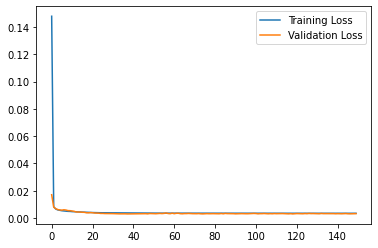

In [ ]:
#1D-CNN Autoencoder (Latent Space = Flaten Vector):

# Parameters:
dropoutrate = 0.15
kernel_size = 3
encoded_dim = 80
modelsavefile = '/content/drive/MyDrive/FaceLandmarks_numpy/Models/conv_autoencoder_vector.h5'

#Build Encoder.
encoder_vector = Sequential([ #2D convs
Conv1D(filters = 15, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "he_uniform", input_shape= (total_instances_trans.shape[1], total_instances_trans.shape[2])),
MaxPooling1D(3),
BatchNormalization(),
Dropout(dropoutrate),
Conv1D(filters = 30, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "he_uniform"),
MaxPooling1D(3),
BatchNormalization(),
Dropout(dropoutrate),
Conv1D(filters = 45, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "he_uniform"),
MaxPooling1D(2),
BatchNormalization(),
Dropout(dropoutrate),
Conv1D(filters = 2, kernel_size = kernel_size, activation='leaky_relu', padding='same', kernel_initializer = "he_uniform"),
Flatten(),
Dense(encoded_dim, activation='relu', kernel_initializer = "he_uniform"),
])

#Build Decoder.
decoder_vector = Sequential ([
Dense(78, activation='relu', kernel_initializer = "he_uniform", input_shape=(encoded_dim,)),
Reshape((26,3)),
Conv1D(filters = 45, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "he_uniform"),
UpSampling1D(2),
BatchNormalization(),
Conv1D(filters = 30, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "he_uniform"),
UpSampling1D(3),
BatchNormalization(),
Conv1D(filters=15, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "he_uniform"),
UpSampling1D(3),
BatchNormalization(),
Conv1D(filters=2, kernel_size = 1, padding="same", kernel_initializer = "he_uniform", activation = "linear")
])

#Merge models to Autoencoder.
input = Input(shape=(total_instances_trans.shape[1], total_instances_trans.shape[2]))
output = encoder_vector(input)
output = decoder_vector(output)
conv_autoencoder_vector = Model(inputs = input, outputs = output)
nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) #adam
conv_autoencoder_vector.compile(optimizer=nadam, loss='mse')
conv_autoencoder_vector.summary()
conv_autoencoder_vector.layers[1].summary()
conv_autoencoder_vector.layers[2].summary()

#cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelsavefile, monitor='val_mae', mode='min', verbose=1,save_weights_only=False,save_best_only=True)
#cb_earlystop = tf.keras.callbacks.EarlyStopping(patience=20,monitor='val_mae',mode='min',verbose=1,restore_best_weights=True)

#history = conv_autoencoder_vector.fit(train, train, batch_size=256, epochs=1000, validation_split=0.2, callbacks=[cb_checkpoint, cb_earlystop])

history = conv_autoencoder_vector.fit(train, train, batch_size=256, epochs=150, validation_split=0.2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


In [ ]:
conv_autoencoder_vector.save('conv_autoencoder_vector.h5')
#new_model = keras.models.load_model('path_to_my_model.h5')

In [ ]:
encoder_vector.save('/content/drive/MyDrive/FaceLandmarks_numpy/encoder_vector.h5')
decoder_vector.save('/content/drive/MyDrive/FaceLandmarks_numpy/decoder_vector.h5')

-------------------- Test Evaluation Results--------------------
X RMSE - Mean: 0.047856534494290164
X RMSE - Max: 0.19785158950353898

Y RMSE - Mean: 0.04687053151717585
Y RMSE - Max: 0.2790641007994403



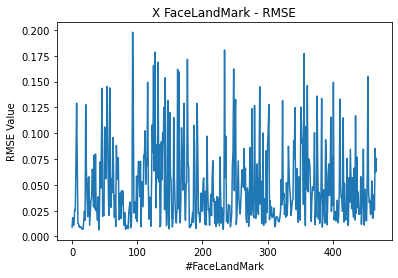

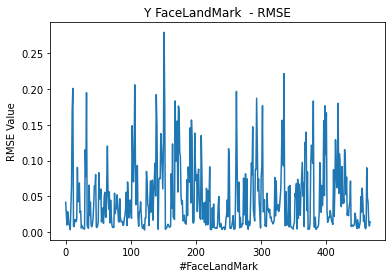

In [ ]:
#Calculate Test dataset RMSE - Conv Autoencoder (Latent Space = Vector)
test_pred = conv_autoencoder_vector.predict(test)

#test_pred = test_pred.transpose(0,2,1)
#test = test.transpose(0,2,1)

print("-------------------- Test Evaluation Results--------------------")
test_mae_loss = np.sqrt(np.mean(((test_pred - test)*(test_pred - test)), axis=0))

x_rmse = test_mae_loss[:,0]
print("X RMSE - Mean:", np.mean(x_rmse, axis=0))
print("X RMSE - Max:", np.max(x_rmse, axis=0))
print("")
y_rmse = test_mae_loss[:,1]
print("Y RMSE - Mean:", np.mean(y_rmse, axis=0))
print("Y RMSE - Max:", np.max(y_rmse, axis=0))
print("")

facelandmarks = np.array(list(range(0, len(x_rmse))))

plt.title("X FaceLandMark - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,x_rmse) 
plt.show()

plt.title("Y FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,y_rmse) 
plt.show()

In [ ]:
#conv_autoencoder_vector = tf.keras.models.load_model('conv_autoencoder_vector.h5')

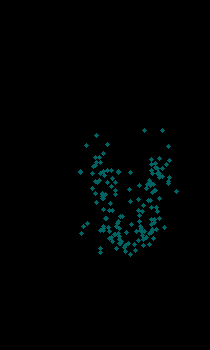

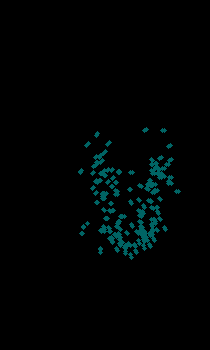

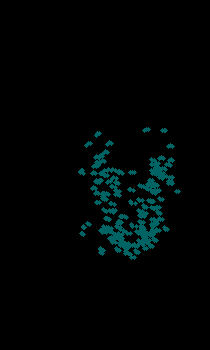

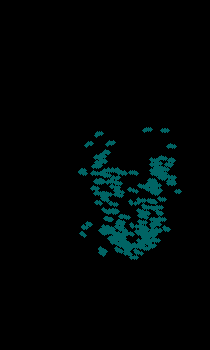

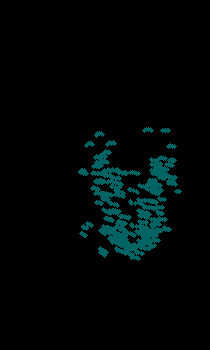

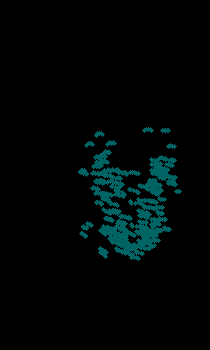

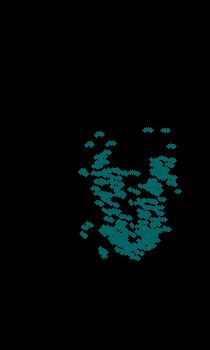

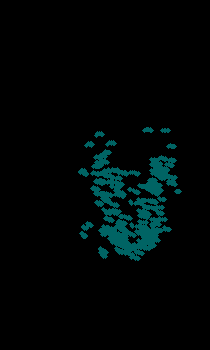

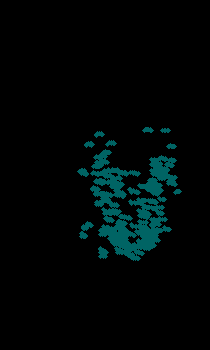

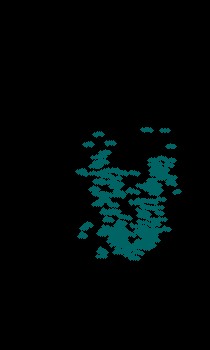

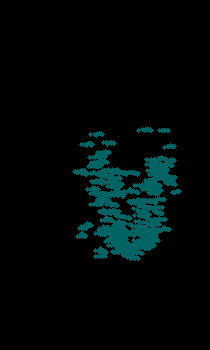

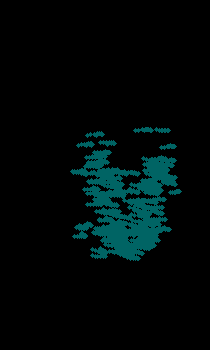

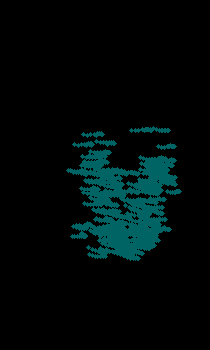

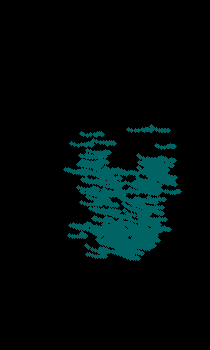

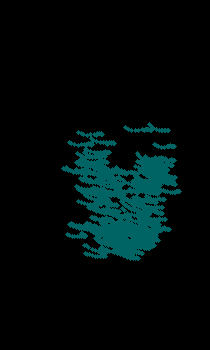

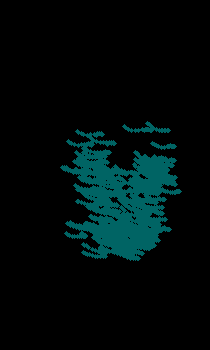

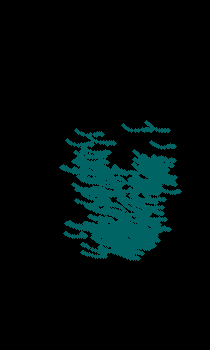

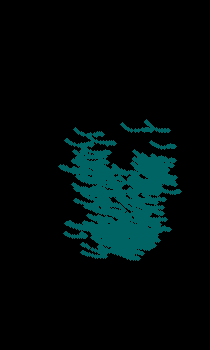

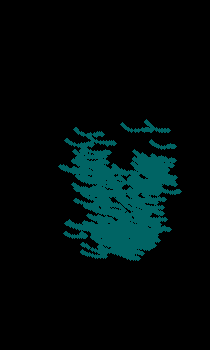

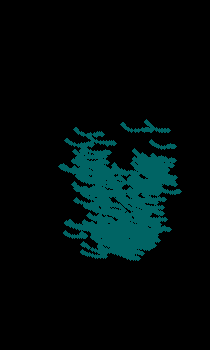

In [ ]:
width = 350
height = 210
from google.colab.patches import cv2_imshow
blank_image = np.zeros((350,210,3), np.uint8)
n_test_sample = 20
fourcc = cv2.VideoWriter_fourcc(*'MJPG')

#for frame in range (len(test_pred)):
for frame in range (n_test_sample):
  facial_landmarks = test_pred[frame]
  #The models generate 468 normalized [x,y,z] facial landmarks. 
  for face_point in facial_landmarks:
    #Denormalize: multiply X coordinate by width and Y coordinate by height.
    x = int(face_point[0] * height)
    y = int(face_point[1] * width)
    #Save tuple of normalized (x,y) coordinates.
    #Attach denormalize facial landmarks to frame.
    cv2.circle(blank_image,(x,y),2,(100,100,0),-1)
  
  cv2_imshow(blank_image)
  cv2.waitKey(0)

## Capacitive Data Processing for Regressor (Using 2DCNN Vector Decoder):

Init Synch (Value,Index): (-72592.98304193467, 552)
Ending Synch (Value,Index): (-476739.81175233424, 7316)


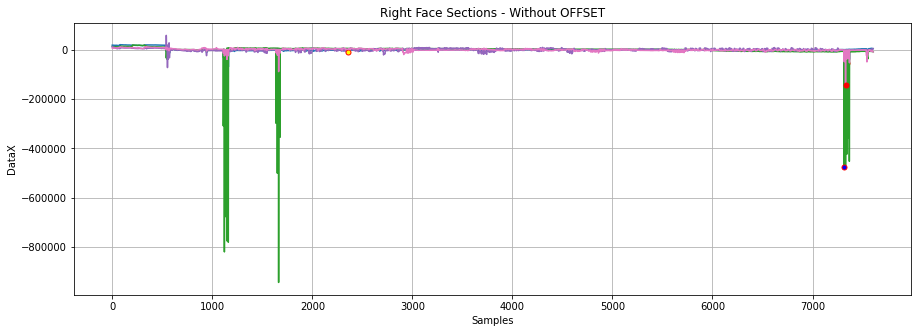

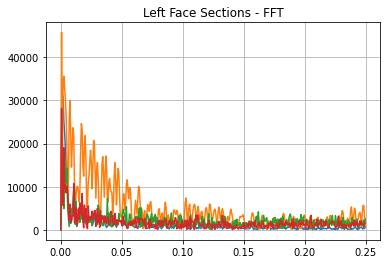

Init Synch (Value,Index): (-116297.2483239118, 552)
Ending Synch (Value,Index): (-515313.0544235576, 7316)


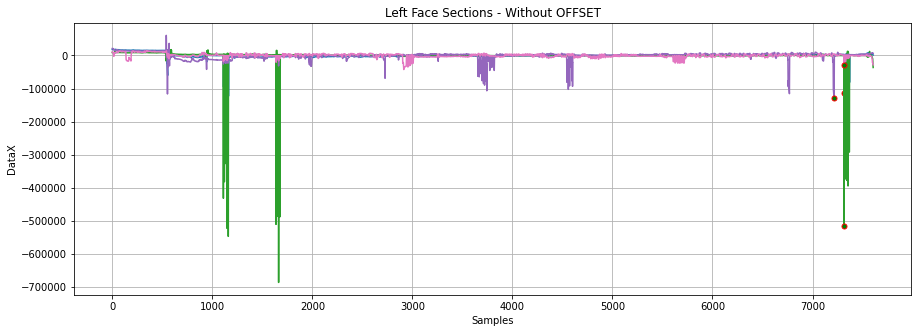

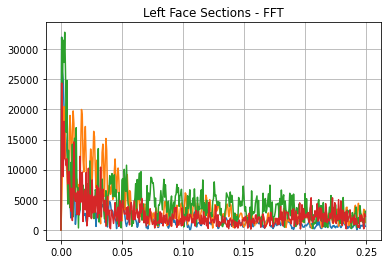

Number of Cap samples in File #1:  7607
Number of Frames in Video #1:  18180
Point Start Synchronization - Video #1: 14
Point End Synchronization - Video #1: 18092
Number of Samples Video #1 - FacelandMarks after Sync:  18076
Number of Samples File #1 - Capacitive Data after Sync:  7234


NameError: ignored

In [ ]:
data_from_videos = 1
n_samples = 1
downsample = 3
window_cap_size = 20 #(2 secs)
n_feature_values = 8
features_cap_timeslice = []
targets_facelandmark_timeslice = []

for i in range(n_samples):
    if (data_from_videos):
      # Change name of file to read.
      file_number = str(i+1)
      file_name_cap = "/content/drive/MyDrive/Capacitive_Data/Cap_Data(" + file_number + ").json"
      video_path = "/content/drive/MyDrive/Video_FaceShield/Video_FaceShield(" + file_number + ").MOV"
      # Read Excel file.
      dataset_cap = get_capacitive_values(file_name_cap)
      # Read FaceLandmarks from Video.
      dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found_init, frame_hand_found_end = get_facelandmarks_video(video_path)
      
      print("Number of Cap samples in File #" + str(file_number) + ": ", len(dataset_cap))
      print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
      print("Point Start Synchronization - Video #" + str(file_number) + ":", frame_hand_found_init)
      print("Point End Synchronization - Video #" + str(file_number) + ":", frame_hand_found_end)
      
      #Manual Sync:
      #Synchronization between Capacitive and FaceLandmarks data.
      sync_thr = 30
      dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z = sync_facelandmarks(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found_init, sync_thr)
      sync_dataset_cap = sync_cap(dataset_cap, frame_hand_found_init, sync_thr)

      print("Number of Samples Video #" + str(file_number) + " - FacelandMarks after Sync: " , len(dataset_facelandmarks_x))
      print("Number of Samples File #" + str(file_number) + " - Capacitive Data after Sync: " , len(sync_dataset_cap))

      #Capacitive data channel Normalization.
      norm_dataset_cap = normalize_capacitance_values(sync_dataset_cap)

      # Generate train features and target from windowing process.
      features = generate_input_time_slices(norm_dataset_cap, window_cap_size, n_feature_values)
      targets = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
      
      
      #CHANGE:
      if (len(features)>len(targets)):
        features = features[0:len(targets)]
      else:
        targets = targets[0:len(features)]

      np.save("/content/drive/MyDrive/FaceLandmarks_numpy/Video_FaceShield_target("+ file_number +").npy", targets)
      np.save("/content/drive/MyDrive/FaceLandmarks_numpy/Cap_FaceShield_feature("+ file_number +").npy", features)

    else:
      video_path = "/content/drive/MyDrive/FaceLandmarks_numpy/Video_FaceShield(" + file_number + ").npy"
      instance = np.load(video_path)
      print("Number of Frames in Video #" + str(file_number) + ": ", len(instance))
      #Eliminate Z channel:
      new_instance = []
      for data in instance:
        new_instance.append([data[0],data[1]])
      instance = np.asarray(new_instance)   

    # If it is the first generation of time features.
    if (i == 0):
        total_features = features
        total_targets = targets
    # If it is not the first generation of time features.
    else:
        total_features = np.concatenate((total_features, features), axis=0)
        total_targets = np.concatenate((total_targets, targets), axis=0)

print("-------------------- Features & Target Dimensions --------------------")

print("Shape of Capacitive Data as Features:", total_features.shape)
print("Shape of Video Data as Targets:", total_targets.shape)

In [ ]:
np.save("/content/drive/MyDrive/FaceLandmarks_numpy/Video_FaceShield_target("+ file_number +").npy", targets)

In [ ]:
#np.save("/content/drive/MyDrive/FaceLandmarks_numpy/Cap_FaceShield_feature("+ file_number +").npy", features)
features = np.load("/content/drive/MyDrive/FaceLandmarks_numpy/Cap_FaceShield_feature("+ file_number +").npy")

In [ ]:
###### TRAIN Images ######
n_videos_train = 1
i = 0
for videos_samples in range(n_videos_train):
  vid = str(videos_samples + 1)
  facelandmarks_path = "/content/drive/MyDrive/FaceLandmarks_numpy/Video_FaceShield_target(" + vid + ").npy"
  instance = np.load(facelandmarks_path)
  print("Number of Samples: ", len(instance))
  
  for face_point in instance:
    x = face_point[1]
    y = face_point[0]
    plt.scatter(x, y, color='white', alpha=0.4, s=100)
    ax = plt.axes()
    ax.set_facecolor("black")

    name = "/content/drive/MyDrive/Image_FaceShieldPoints/myfig" + str(i) + ".png"
    plt.savefig(name, bbox_inches='tight', pad_inches=0)

    image = Image.open(name)
    width, height = image.size
    crop_img = image.crop((25,5,width-5,height-20))
    crop_img = crop_img.resize((int(width*1.1),int(height*1.1)),Image.BICUBIC)

    width, height = crop_img.size
    right = int((510 - width)/2)
    left = int((510 - width)/2)
    top = int((510 - height)/2)
    bottom = int((510 - height)/2)
        
    new_width = width + right + left
    new_height = height + top + bottom
      
    result = Image.new(crop_img.mode, (new_width, new_height), (0, 0, 0))
    result.paste(crop_img, (left, top))

    angle = 270
    out = result.rotate(angle, expand=True) 

    output = out.resize((255,255),Image.BICUBIC)
    output.save(name, format="png")
    
    i = i + 1
    plt.clf()

n_samples_train = i
print("Number of Images - Train", n_samples_train)

Number of Samples:  6025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Number of Images - Train 6025


<Figure size 432x288 with 0 Axes>

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint
#n_samples_train = 59498
n_samples_train = 6025
### Preprocessing of TRAIN Images ###
i = 0
train = []
for i in range(n_samples_train-2):
    # Change name of file to read.
    img_number = str(i+1)
    img_path = "/content/drive/MyDrive/Image_FaceShieldPoints/myfig" + img_number + ".png"
    a = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (256, 256), interpolation = cv2.INTER_CUBIC)
    a = a[..., np.newaxis]
    train.append(a)

train = np.asarray(train)
train = train/255.
#Aumentamos la data de TRAIN ya que tenemos pocas imagánes y las normalizamos:
#train_datagenerator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.05,
#                                         height_shift_range = 0.05, shear_range = 0.05, zoom_range = 0.05,
 #                                        horizontal_flip = False,)

#Aplicamos los objetos de Data Generator a nuestos datasets:
#train_set = train_datagenerator.flow(train, batch_size = 64)

print("-------------------- Total Images --------------------")
print("Total size TRAIN Set:", train.shape)

-------------------- Total Images --------------------
Total size TRAIN Set: (6023, 256, 256, 1)


In [ ]:
encoded_pred = encoder_CNN.predict(train)

In [ ]:
encoded_pred.shape

(6023, 100)

In [ ]:
features = features[0:6023]
features.shape

(100, 20, 8)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 19, 32)            544       
                                                                 
 batch_normalization_8 (Batc  (None, 19, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 32)            2080      
                                                                 
 batch_normalization_9 (Batc  (None, 18, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 18, 32)            0         
                                                                 
 flatten_3 (Flatten)         (None, 576)              

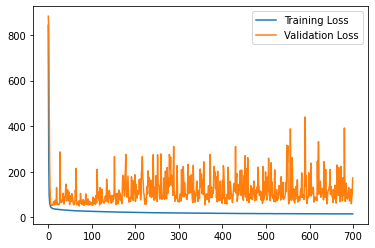

In [ ]:
#Prepare data for CNN model.
x_train = features
#n_output = enconded dimension.
n_output = encoded_pred.shape[1]
y_train = encoded_pred

#CNN:
# Parameters:
n_filters = 32
EPOCHS_CNN = 700

# Define architecture of CNN.
model_CNN = Sequential()
model_CNN.add(Conv1D(filters=n_filters, kernel_size=2, activation='relu', kernel_initializer = "he_uniform", input_shape=(x_train.shape[1], x_train.shape[2])))
model_CNN.add(BatchNormalization())
model_CNN.add(Conv1D(filters=n_filters, kernel_size=2, activation='relu', kernel_initializer = "he_uniform"))
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.2))
model_CNN.add(Flatten())
model_CNN.add(Dense(50, activation='relu', kernel_initializer = "glorot_uniform"))
model_CNN.add(Dense(n_output))

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_CNN.compile(loss='mse', optimizer=nadam, metrics=['mse'])
# Show summary of model.
model_CNN.summary()
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history_CNN = model_CNN.fit(x_train, y_train, batch_size=128, validation_split=0.2, epochs=EPOCHS_CNN)

plt.plot(history_CNN.history["loss"], label="Training Loss")
plt.plot(history_CNN.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
model_CNN.save('/content/drive/MyDrive/FaceLandmarks_numpy/model_CNN_regresor.h5')

-------------------- Test Evaluation Results--------------------
Test RMSE 1D-CNN [0.796798   0.08325911 0.57067424 0.49761844 0.841718   0.5703242
 0.04502771 0.09038826 0.07753039 0.04518587 0.04677032 0.04953602
 0.04400155 0.08771518 0.06571757]

RMSE - Mean: 0.26081765
RMSE - Max: 0.841718



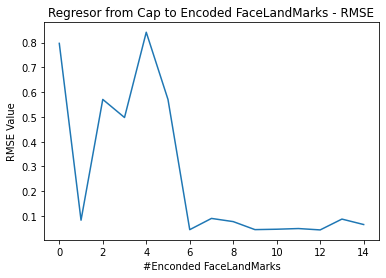

In [ ]:
#### Calculate Test dataset RMSE for 1D-CNN ####
test_pred = model_CNN.predict(X_test)

print("-------------------- Test Evaluation Results--------------------")
test_rmse_loss = np.sqrt(np.mean(((test_pred - y_test)*(test_pred - y_test)), axis=0))
print("Test RMSE 1D-CNN", test_rmse_loss)
print("")
print("RMSE - Mean:", np.mean(test_rmse_loss, axis=0))
print("RMSE - Max:", np.max(test_rmse_loss, axis=0))
print("")

enconder_dimension = np.array(list(range(0, len(test_rmse_loss))))
plt.title("Regresor from Cap to Encoded FaceLandMarks - RMSE") 
plt.xlabel("#Enconded FaceLandMarks") 
plt.ylabel("RMSE Value") 
plt.plot(enconder_dimension,test_rmse_loss) 
plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 80)                12880     
                                                                 
 dropout_7 (Dropout)         (None, 80)                0         
                                                                 
 dense_11 (Dense)            (None, 60)                4860      
                                                                 
 dropout_8 (Dropout)         (None, 60)                0         
                                                                 
 dense_12 (Dense)            (None, 40)                2440      
                                                                 
 dense_13 (Dense)            (None, 15)                615       
                                                                 
Total params: 20,795
Trainable params: 20,795
Non-trai

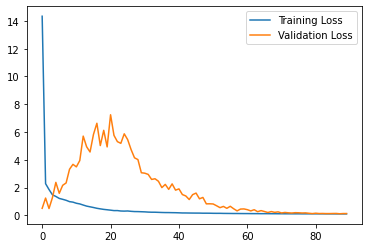

In [ ]:
#Prepare data for MLP model.
x_train = X_train
#Flaten train vector.
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
#n_output = enconded dimension.
n_output = y_train.shape[1]

EPOCHS_MLP = 90

model_MLP = Sequential()
model_MLP.add(Dense(80, activation='relu', input_dim=x_train.shape[1], kernel_initializer = "glorot_uniform"))
model_CNN.add(BatchNormalization())
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(60, activation='relu', kernel_initializer = "glorot_uniform"))
model_CNN.add(BatchNormalization())
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(40, activation='relu', kernel_initializer = "glorot_uniform"))
model_MLP.add(Dense(n_output))

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_MLP.compile(loss='mse', optimizer=nadam, metrics=['mse']) #incluir R2
# Show summary of model.
model_MLP.summary()
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history_MLP = model_MLP.fit(x_train, y_train, batch_size=32, validation_split=0.20, epochs=EPOCHS_MLP)

plt.plot(history_MLP.history["loss"], label="Training Loss")
plt.plot(history_MLP.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

-------------------- Test Evaluation Results--------------------
Test RMSE MLP [0.7580896  0.00313091 0.3098382  0.49128154 0.8038851  0.5667385
 0.00214009 0.03738342 0.02013993 0.00335107 0.00576159 0.00412634
 0.00249092 0.00266585 0.00315577]

RMSE - Mean: 0.20094524
RMSE - Max: 0.8038851



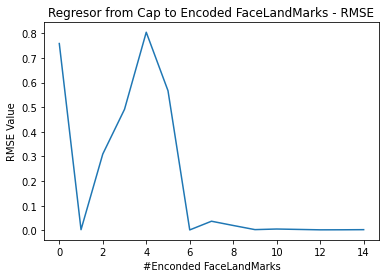

In [ ]:
#### Calculate Test dataset RMSE for MLP ####
x_test = X_test
#Flaten train vector.
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))
test_pred = model_MLP.predict(x_test)

print("-------------------- Test Evaluation Results--------------------")
test_rmse_loss = np.sqrt(np.mean(((test_pred - y_test)*(test_pred - y_test)), axis=0))
print("Test RMSE MLP", test_rmse_loss)
print("")
print("RMSE - Mean:", np.mean(test_rmse_loss, axis=0))
print("RMSE - Max:", np.max(test_rmse_loss, axis=0))
print("")

enconder_dimension = np.array(list(range(0, len(test_rmse_loss))))
plt.title("Regresor from Cap to Encoded FaceLandMarks - RMSE") 
plt.xlabel("#Enconded FaceLandMarks") 
plt.ylabel("RMSE Value") 
plt.plot(enconder_dimension,test_rmse_loss) 
plt.show()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_38 (Reshape)        (None, 20, 8, 1)          0         
                                                                 
 bidirectional_47 (Bidirecti  (None, 20, 8, 39)        62712     
 onal)                                                           
                                                                 
 dropout_77 (Dropout)        (None, 20, 8, 39)         0         
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 6, 4, 39)         0         
 g2D)                                                            
                                                                 
 bidirectional_48 (Bidirecti  (None, 6, 4, 78)         365664    
 onal)                                                           
                                                     

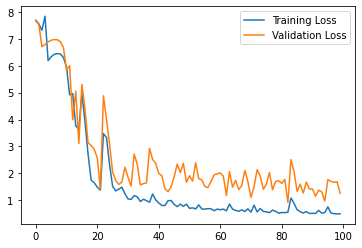

In [ ]:
#Prepare data for ConvLSTM1D model (Use encoder_matrix)
x_train = X_train
#n_output = enconded dimension.
n_output = (y_train.shape[1], y_train.shape[2])

# Parameters:
EPOCHS_CNN = 100
kernel_size = 5

regressor = Sequential([
layers.Input((x_train.shape[1], x_train.shape[2])),
layers.Reshape((x_train.shape[1], x_train.shape[2],1)),
layers.Bidirectional(layers.ConvLSTM1D(filters = 39, kernel_size = kernel_size, padding='same', activation='relu', return_sequences=True), merge_mode='sum'),
layers.Dropout(dropoutrate),
layers.MaxPooling2D(pool_size=(3, 2)),
layers.Bidirectional(layers.ConvLSTM1D( filters = 78, kernel_size = kernel_size, padding='same', activation='relu', return_sequences=True), merge_mode='sum'),
layers.Dropout(dropoutrate),
layers.MaxPooling2D(pool_size=(4, 3)),
layers.Reshape((y_train.shape[1], y_train.shape[2]))
])

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
regressor.compile(optimizer=nadam, loss='mse')
regressor.summary()

history_regressor = regressor.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=EPOCHS_CNN)
plt.plot(history_regressor.history["loss"], label="Training Loss")
plt.plot(history_regressor.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Complete Model Evaluation:

Init Synch (Value,Index): (-72592.98304193467, 552)
Ending Synch (Value,Index): (-476739.81175233424, 7316)


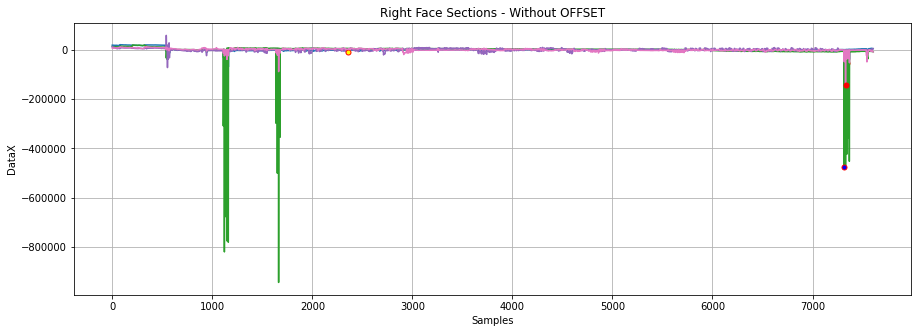

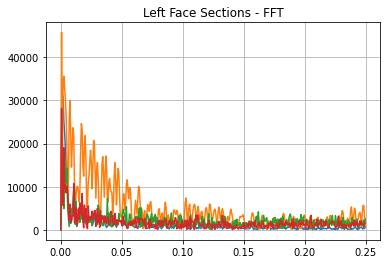

Init Synch (Value,Index): (-116297.2483239118, 552)
Ending Synch (Value,Index): (-515313.0544235576, 7316)


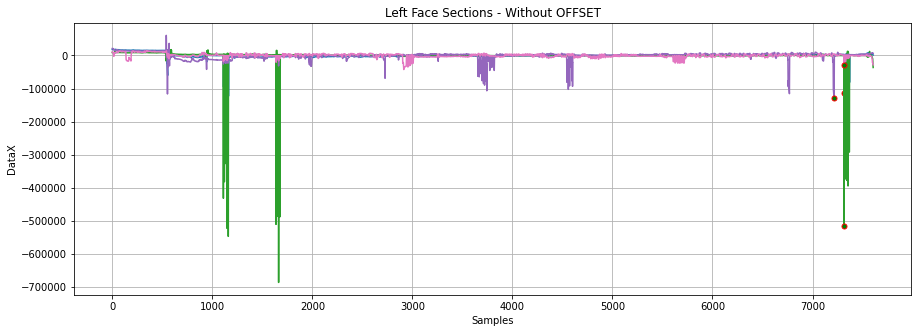

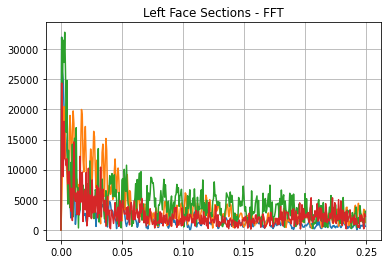

Number of Cap samples in File #1:  7607


NameError: ignored

In [ ]:
n_samples = 1
n_test_sets = 1
downsample = 3
window_cap_size = 20 #(2 secs)
n_feature_values = 8
features_cap_timeslice = []
targets_facelandmark_timeslice = []

for i in range(n_samples):
    #Reading EXCEL file coming from SerialPort data:
    # Change name of file to read.
    file_number = str(i+1)
    file_name_cap = "/content/drive/MyDrive/Capacitive_Data_Test/Cap_Data_Test(" + file_number + ").json"
    #video_path = "/content/drive/MyDrive/Video_FaceShield_Test (" + file_number + ").MOV"
    # Read Excel file.
    dataset_cap = get_capacitive_values(file_name_cap)
    # Read FaceLandmarks from Video.
    #dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found = get_facelandmarks_video(video_path)
    #frame_hand_found = 480
    print("Number of Cap samples in File #" + str(file_number) + ": ", len(dataset_cap))
    #print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    
   #Capacitive data channel Normalization.
    norm_dataset_cap = normalize_capacitance_values(dataset_cap)

    # Generate train features and target from windowing process.
    features = generate_input_time_slices(dataset_cap, window_cap_size, n_feature_values)
    #targets = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    
    #CHANGE (MISSING DATA SYNCHRONIZATION)
    #if (len(features)>len(targets)):
    #  features = features[0:len(targets)]
    #else:
    #  targets = targets[0:len(features)]

    # If it is the first generation of time features.
    if (i == 0):
        total_features = features
        total_targets = targets
    # If it is not the first generation of time features.
    else:
        total_features = np.concatenate((total_features, features), axis=0)
        total_targets = np.concatenate((total_targets, targets), axis=0)
          
print("-------------------- Features & Target Dimensions --------------------")
print("Shape of Capacitive Data as Features:", total_features.shape)
print("Shape of Encoded FaceLandMark points as Targets:", total_targets.shape)

In [ ]:
model_CNN_regresor = tf.keras.models.load_model('/content/drive/MyDrive/Models/model_CNN_regresor.h5')

In [ ]:
total_features

In [ ]:
features = features[10:100]
a = model_CNN_regresor.predict(features)

In [ ]:
test_pred = decoder_CNN.predict(a)

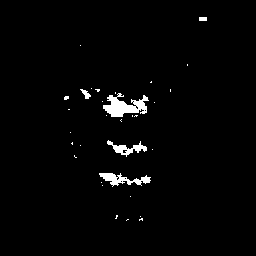

In [ ]:
img = test_pred[28]*255.
img = img.astype(int)
img = img[:, :, 0]
cv2_imshow(img)

-------------------- Test Evaluation Results--------------------
X RMSE - Mean: 0.45750479562910656
X RMSE - Max: 0.6523785574767492

Y RMSE - Mean: 0.3423428004682712
Y RMSE - Max: 0.48082910598991374

Z RMSE - Mean: 0.13842283463096647
Z RMSE - Max: 1.0571890279574347



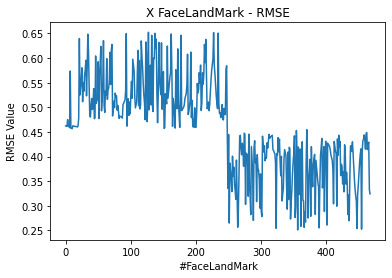

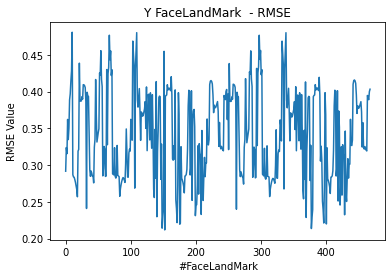

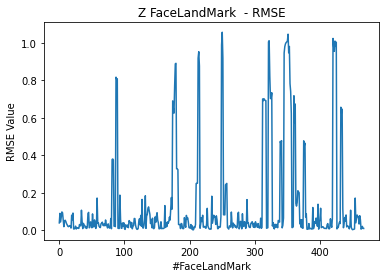

In [ ]:
#### Calculate Test RMSE for complete Model ####

#For MLP - Flaten features vector.
#Concatenate MLP Regressor and Decoder.
cap_face_model = Model(inputs = model_MLP.inputs, outputs = decoder_vector(model_MLP.outputs))
x_test = total_features.reshape((total_features.shape[0], total_features.shape[1]*total_features.shape[2]))
y_test = total_targets
y_test = y_test.transpose(0,2,1)

#For 1DCNN - Flaten features vector.
#Concatenate 1DCNN Regressor and Decoder.
#cap_face_model = Model(inputs = model_CNN.inputs, outputs = decoder_vector(model_CNN.outputs))
#x_test = total_features
#y_test = total_targets
#y_test = y_test.transpose(0,2,1)

#Compute predictions with complete model:
test_pred = cap_face_model.predict(x_test)

#Print evaluation results - RMSE:
print("-------------------- Test Evaluation Results--------------------")

#Calculate RMSE:
test_rmse_loss = np.sqrt(np.mean(((test_pred - y_test)*(test_pred - y_test)), axis=0))

x_rmse = test_rmse_loss[:,0]
print("X RMSE - Mean:", np.mean(x_rmse, axis=0))
print("X RMSE - Max:", np.max(x_rmse, axis=0))
print("")
y_rmse = test_rmse_loss[:,1]
print("Y RMSE - Mean:", np.mean(y_rmse, axis=0))
print("Y RMSE - Max:", np.max(y_rmse, axis=0))
print("")
z_rmse = test_rmse_loss[:,2]
print("Z RMSE - Mean:", np.mean(z_rmse, axis=0))
print("Z RMSE - Max:", np.max(z_rmse, axis=0))
print("")

facelandmarks = np.array(list(range(0, len(x_rmse))))

plt.title("X FaceLandMark - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,x_rmse) 
plt.show()

plt.title("Y FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,y_rmse) 
plt.show()

plt.title("Z FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,z_rmse) 
plt.show()

In [ ]:
test_pred.shape
test_pred = test_pred.transpose(0,2,1)
test_pred.shape

(10230, 468, 3)

In [ ]:
y_test.shape

(10230, 468, 3)

In [ ]:
facial_landmarks

0

In [ ]:
width = 350
height = 210
from google.colab.patches import cv2_imshow
blank_image = np.zeros((350,210,3), np.uint8)
n_test_sample = 20
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter("/content/drive/MyDrive/output_test", fourcc, 30.0, (350,210))

#for frame in range (len(test_pred)):
for frame in range (n_test_sample):
  facial_landmarks = test_pred[frame]
  #The models generate 468 normalized [x,y,z] facial landmarks. 
  for face_point in facial_landmarks:
    #Denormalize: multiply X coordinate by width and Y coordinate by height.
    x = int(face_point[0] * height)
    y = int(face_point[1] * width)
    #Save tuple of normalized (x,y) coordinates.
    #Attach denormalize facial landmarks to frame.
    cv2.circle(blank_image,(x,y),2,(100,100,0),-1)
  
  out.write(blank_image)
  cv2_imshow(blank_image)
  cv2.waitKey(0)